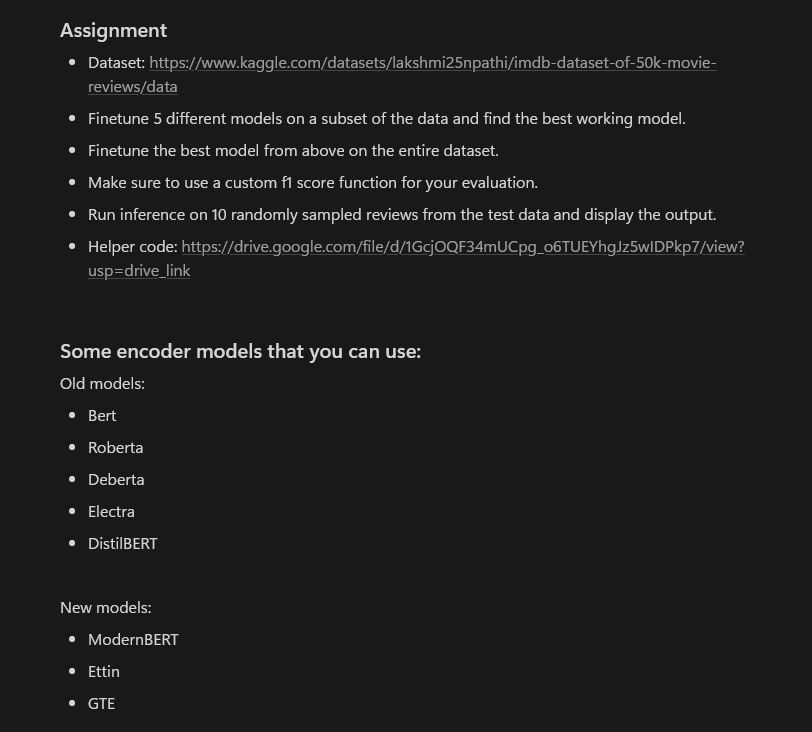

In [2]:
!pip install "accelerate>=0.26.0,<0.27.0"

In [4]:
!pip install "tokenizers>=0.21,<0.22"

  Obtaining dependency information for tokenizers<0.22,>=0.21 from https://files.pythonhosted.org/packages/41/f2/fd673d979185f5dcbac4be7d09461cbb99751554ffb6718d0013af8604cb/tokenizers-0.21.4-cp39-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
    --------------------------------------- 0.0/2.5 MB 991.0 kB/s eta 0:00:03
   ------- -------------------------------- 0.5/2.5 MB 5.6 MB/s eta 0:00:01
   --------------------- ------------------ 1.3/2.5 MB 10.6 MB/s eta 0:00:01
   ----------------------------------- ---- 2.3/2.5 MB 13.0 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 12.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.0
    Uninstalling tokenizers-0.22.0:
      Successfully uninstalled tokenizers-0.22.0


In [1]:
import accelerate, transformers, torch
print("accelerate:", accelerate.__version__)
print("transformers:", transformers.__version__)
print("torch:", torch.__version__)

accelerate: 0.26.1
transformers: 4.50.3
torch: 2.6.0+cu126


In [1]:
import numpy as np
import torch
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    pipeline,
)
from sklearn.metrics import f1_score, accuracy_score
import random
import os
import sys

# Define a custom metric computation function
# The Trainer API requires a function that takes EvalPrediction and returns a dictionary
def compute_metrics(eval_pred):
    """
    Computes accuracy and F1 score for model evaluation.
    
    Args:
        eval_pred (EvalPrediction): A tuple containing model predictions and true labels.
    
    Returns:
        dict: A dictionary with 'accuracy' and 'f1' scores.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # The f1_score function is calculated with a 'binary' average for two classes.
    f1 = f1_score(labels, predictions, average='binary')
    accuracy = accuracy_score(labels, predictions)
    return {"f1": f1, "accuracy": accuracy}

def tokenize_function(examples, tokenizer):
    """
    Tokenizes a batch of text examples.
    """
    return tokenizer(examples["text"], padding="max_length", truncation=True)

def finetune_and_evaluate(model_name, dataset, tokenizer, training_args, subset_size=None):
    """
    Fine-tunes and evaluates a model on a given dataset.
    
    Args:
        model_name (str): The name of the model from the Hugging Face Hub.
        dataset (DatasetDict): The dataset to use for training and evaluation.
        tokenizer (PreTrainedTokenizer): The tokenizer to use.
        training_args (TrainingArguments): The training arguments.
        subset_size (int, optional): The number of examples to use for the subset.
                                     If None, uses the full dataset.
    
    Returns:
        dict: A dictionary containing the evaluation metrics.
    """
    print(f"\n--- Fine-tuning and evaluating {model_name} ---")
    
    # Load the model for sequence classification
    try:
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=2,
            ignore_mismatched_sizes=True
        )
    except Exception as e:
        print(f"Could not load model {model_name}. Skipping. Error: {e}")
        return {"f1": 0, "accuracy": 0}
        
    # Prepare the subset if specified
    if subset_size:
        print(f"Using a subset of {subset_size} samples for training and evaluation.")
        train_dataset = dataset["train"].shuffle(seed=42).select(range(subset_size))
        eval_dataset = dataset["test"].shuffle(seed=42).select(range(int(subset_size * 0.2)))
    else:
        print("Using the entire dataset for training and evaluation.")
        train_dataset = dataset["train"]
        eval_dataset = dataset["test"]

    # Tokenize the datasets
    tokenized_train_dataset = train_dataset.map(lambda examples: tokenize_function(examples, tokenizer), batched=True)
    tokenized_eval_dataset = eval_dataset.map(lambda examples: tokenize_function(examples, tokenizer), batched=True)

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_eval_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
    )
    
    # Train the model
    trainer.train()
    
    # Evaluate the model
    eval_results = trainer.evaluate()
    print(f"Evaluation results for {model_name}: {eval_results}")
    
    return eval_results

def main():
    try:
        # Set up device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        # Step 1: Load the dataset from local file
        print("\n--- Step 1: Loading IMDB dataset from local CSV file ---")
        # IMPORTANT: Replace the path below with the actual path to your IMDB_Dataset.csv file
        local_file_path = r"C:\Users\laava\Desktop\sem 7\NLP\IMDB_Dataset.csv"
        
        if not os.path.exists(local_file_path):
            print(f"Error: The file '{local_file_path}' was not found.")
            print("Please ensure the CSV file is in the same directory as this script or provide the full file path.")
            return

        df = pd.read_csv(local_file_path)
        
        # Rename columns and convert labels for compatibility with the script
        df.rename(columns={'review': 'text', 'sentiment': 'label'}, inplace=True)
        df['label'] = df['label'].map({'positive': 1, 'negative': 0})

        # Split the dataframe into training and testing sets
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
        
        # Convert pandas dataframes to Hugging Face Dataset objects
        train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
        test_dataset = Dataset.from_pandas(test_df, preserve_index=False)
        imdb_dataset = DatasetDict({"train": train_dataset, "test": test_dataset})
        
        print("Successfully loaded and prepared the local dataset.")

        # Step 2: Define models to test and their tokenizers
        print("\n--- Step 2: Defining models to test ---")
        models_to_test = {
            "distilbert-base-uncased": AutoTokenizer.from_pretrained("distilbert-base-uncased"),
            "bert-base-uncased": AutoTokenizer.from_pretrained("bert-base-uncased"),
            "roberta-base": AutoTokenizer.from_pretrained("roberta-base"),
            "google/electra-small-discriminator": AutoTokenizer.from_pretrained("google/electra-small-discriminator"),
            "GTE-small": AutoTokenizer.from_pretrained("TaylorAI/gte-tiny"),
        }
        
        # Define training arguments for the subset fine-tuning
        subset_train_args = TrainingArguments(
            output_dir="./subset_results",
            # Updated deprecated parameter to eval_strategy
            eval_strategy="epoch",
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            # Reduced epochs for faster testing
            num_train_epochs=1,
            weight_decay=0.01,
            logging_dir='./subset_logs',
            save_strategy="epoch",
            load_best_model_at_end=True,
            save_steps=500,
            save_total_limit=1,
        )

        # Step 3: Fine-tune and evaluate models on a subset
        print("\n--- Step 3: Fine-tuning and evaluating models on a subset ---")
        subset_results = {}
        subset_size = 5000  # Use a subset of 5000 examples
        
        for model_name, tokenizer in models_to_test.items():
            results = finetune_and_evaluate(model_name, imdb_dataset, tokenizer, subset_train_args, subset_size)
            subset_results[model_name] = results
        
        # Find the best model based on F1 score
        if not subset_results:
            print("\nError: No models were successfully evaluated.")
            return

        best_model_name = max(subset_results, key=lambda k: subset_results[k].get("eval_f1", 0))
        print(f"\n--- Best model from subset fine-tuning is: {best_model_name} with F1 score: {subset_results[best_model_name].get('eval_f1')} ---")

        # Step 4: Fine-tune the best model on the entire dataset
        print(f"\n--- Step 4: Fine-tuning {best_model_name} on the entire dataset ---")
        
        # Define training arguments for full dataset fine-tuning
        full_train_args = TrainingArguments(
            output_dir=f"./full_dataset_results_{best_model_name.replace('/', '_')}",
            # Updated deprecated parameter to eval_strategy
            eval_strategy="epoch",
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            # Increased epochs for better performance on the full dataset
            num_train_epochs=2,
            weight_decay=0.01,
            logging_dir='./full_dataset_logs',
            save_strategy="epoch",
            load_best_model_at_end=True,
            save_steps=500,
            save_total_limit=1,
        )

        # Load the tokenizer for the best model
        best_model_tokenizer = models_to_test[best_model_name]

        # Perform the final fine-tuning
        finetune_and_evaluate(best_model_name, imdb_dataset, best_model_tokenizer, full_train_args)

        # Step 5: Inference on 10 random samples
        print("\n--- Step 5: Running inference on 10 random samples from the test set ---")
        
        # Load the fine-tuned model for inference
        inference_model_path = full_train_args.output_dir
        final_model = AutoModelForSequenceClassification.from_pretrained(inference_model_path)
        final_tokenizer = best_model_tokenizer

        # Create a text classification pipeline
        classifier = pipeline(
            "text-classification",
            model=final_model,
            tokenizer=final_tokenizer,
            device=0 if torch.cuda.is_available() else -1,
            return_all_scores=False
        )
        
        # Get 10 random samples from the test set
        test_samples = imdb_dataset["test"].shuffle(seed=42).select(range(10))
        
        label_map = {0: "Negative", 1: "Positive"}
        
        for i, sample in enumerate(test_samples):
            review = sample["text"]
            true_label = label_map[sample["label"]]
            
            # Run inference
            prediction = classifier(review)[0]
            predicted_label = prediction['label']
            confidence = prediction['score']

            print(f"\n--- Review {i+1} ---")
            print(f"Review: {review[:200]}...")
            print(f"True Label: {true_label}")
            print(f"Predicted Label: {predicted_label} (Confidence: {confidence:.4f})")

    except Exception as e:
        print(f"\nAn unexpected error occurred during execution: {e}")
        print("Please check the error message and the code for potential issues.")

if __name__ == "__main__":
    main()


Using device: cuda

--- Step 1: Loading IMDB dataset from local CSV file ---
Successfully loaded and prepared the local dataset.

--- Step 2: Defining models to test ---

--- Step 3: Fine-tuning and evaluating models on a subset ---

--- Fine-tuning and evaluating distilbert-base-uncased ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using a subset of 5000 samples for training and evaluation.


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

C:\Users\laava\AppData\Local\Temp\ipykernel_1040\2943597565.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.361200,0.245779,0.916505,0.914000


Evaluation results for distilbert-base-uncased: {'eval_loss': 0.24577867984771729, 'eval_f1': 0.916504854368932, 'eval_accuracy': 0.914, 'eval_runtime': 20.7969, 'eval_samples_per_second': 48.084, 'eval_steps_per_second': 6.011, 'epoch': 1.0}

--- Fine-tuning and evaluating bert-base-uncased ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using a subset of 5000 samples for training and evaluation.


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

C:\Users\laava\AppData\Local\Temp\ipykernel_1040\2943597565.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.384600,0.247064,0.921154,0.918000


Evaluation results for bert-base-uncased: {'eval_loss': 0.24706369638442993, 'eval_f1': 0.9211538461538461, 'eval_accuracy': 0.918, 'eval_runtime': 55.0224, 'eval_samples_per_second': 18.174, 'eval_steps_per_second': 2.272, 'epoch': 1.0}

--- Fine-tuning and evaluating roberta-base ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using a subset of 5000 samples for training and evaluation.


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

C:\Users\laava\AppData\Local\Temp\ipykernel_1040\2943597565.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.365300,0.211937,0.945946,0.944000


Evaluation results for roberta-base: {'eval_loss': 0.2119373083114624, 'eval_f1': 0.9459459459459459, 'eval_accuracy': 0.944, 'eval_runtime': 91.8152, 'eval_samples_per_second': 10.891, 'eval_steps_per_second': 1.361, 'epoch': 1.0}

--- Fine-tuning and evaluating google/electra-small-discriminator ---


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using a subset of 5000 samples for training and evaluation.


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

C:\Users\laava\AppData\Local\Temp\ipykernel_1040\2943597565.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.425800,0.261622,0.912214,0.908000


Evaluation results for google/electra-small-discriminator: {'eval_loss': 0.26162201166152954, 'eval_f1': 0.9122137404580153, 'eval_accuracy': 0.908, 'eval_runtime': 12.3687, 'eval_samples_per_second': 80.849, 'eval_steps_per_second': 10.106, 'epoch': 1.0}

--- Fine-tuning and evaluating GTE-small ---
Could not load model GTE-small. Skipping. Error: GTE-small is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

--- Best model from subset fine-tuning is: roberta-base with F1 score: 0.9459459459459459 ---

--- Step 4: Fine-tuning roberta-base on the entire dataset ---

--- Fine-tuning and evaluating roberta-base ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using the entire dataset for training and evaluation.


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

C:\Users\laava\AppData\Local\Temp\ipykernel_1040\2943597565.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.250400,0.242584,0.936544,0.934900
2,0.164800,0.224540,0.948022,0.948100


Evaluation results for roberta-base: {'eval_loss': 0.2245398461818695, 'eval_f1': 0.9480220330495743, 'eval_accuracy': 0.9481, 'eval_runtime': 181.6038, 'eval_samples_per_second': 55.065, 'eval_steps_per_second': 6.883, 'epoch': 2.0}

--- Step 5: Running inference on 10 random samples from the test set ---

An unexpected error occurred during execution: Error no file named pytorch_model.bin, model.safetensors, tf_model.h5, model.ckpt.index or flax_model.msgpack found in directory ./full_dataset_results_roberta-base.
Please check the error message and the code for potential issues.
